In [41]:
################## IMPORT LIBRARIES ##################

import numpy as np
import random 
import pandas as pd
import os
from os.path import join as pjoin
import matplotlib.pyplot as plt 

In [42]:
################## IMPORT MY MODULES ##################

import sys
sys.path.append('../src')
import helpers as hlp
import importlib
importlib.reload(hlp);

In [43]:
np.random.seed(42)

# datapath="/media/ssd2/RESULTS-reverb-match-cond-u-net/"
datapath="/home/ubuntu/Data/"

In [45]:
# ---------- SPEECH POOL ------------

# create df with paths to speech files
speech_dataset_path1 =  pjoin(datapath,'VCTK','wav48_silence_trimmed')
speech_dataset_path2 =  pjoin(datapath,'PTDB')
speech_dataset_path3 =  pjoin(datapath,'EARS')

# initialize empty list of files:
speech_pool = []

# fill the list of files with filenames from vctk data base:
database="VCTK"
for root, dirs, files in os.walk(speech_dataset_path1):
    for file in files:
        if file.endswith('.flac'):
            # decide which split based on a probability 
            speech_pool.append({'database_speech': database, 'speech_file_path': os.path.join(root, file)})

# fill the list of files with filenames from ptdb data base:
database="PTDB"
for root, dirs, files in os.walk(speech_dataset_path2):
    for file in files:
        # make sure the correct speech files are used (MIC directory)
        if ("/MIC/" in root) & (file.endswith('.wav')):
            # decide which split based on a probability 
            speech_pool.append({'database_speech': database, 'speech_file_path': os.path.join(root, file)})  


# fill the list of files with filenames from ears data base:
database="EARS"
for root, dirs, files in os.walk(speech_dataset_path3):
    for file in files:
        # make sure the correct speech files are used (MIC directory)
        if file.endswith(('slow.wav','fast.wav','highpitch.wav','lowpitch.wav','regular.wav')):
            # decide which split based on a probability 
            speech_pool.append({'database_speech': database, 'speech_file_path': os.path.join(root, file)})  


# # shuffle order
random.shuffle(speech_pool)

# turn list to data frame 
speech_pool = pd.DataFrame(speech_pool).reset_index(drop=True)
speech_pool.tail(200)
print(f"{len(speech_pool)=}")

# split speech pool into test, train and val (70/15/15)
speech_train=speech_pool[speech_pool.index<int(0.7*len(speech_pool))].reset_index(drop=True)
speech_test=speech_pool[(speech_pool.index>=int(0.7*len(speech_pool))) & (speech_pool.index<int(0.85*len(speech_pool)))].reset_index(drop=True)
speech_val=speech_pool[(speech_pool.index>=int(0.85*len(speech_pool))) & (speech_pool.index<len(speech_pool))].reset_index(drop=True)


print(f"{len(speech_train)=}")
print(f"{len(speech_test)=}")
print(f"{len(speech_val)=}")

len(speech_pool)=100322
len(speech_train)=70225
len(speech_test)=15048
len(speech_val)=15049


In [5]:
print("Separate speech pools for test, train and val:")

display(speech_train.head(5))
display(speech_test.head(5))
display(speech_val.head(5))

Separate speech pools for test, train and val:


,database_speech,speech_file_path
0,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
1,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
2,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
3,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
4,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...


,database_speech,speech_file_path
0,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
1,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
2,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
3,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
4,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...


,database_speech,speech_file_path
0,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
1,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
2,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
3,EARS,/home/ubuntu/Data/EARS/p082/sentences_11_highp...
4,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/s...


In [6]:
# ---------- LOAD RIR PAIRS POOL ------------
# Here we load the info about all generated rirs ("rir_info.csv")
# Those rirs are arranged in pairs (see column "pair_nr")


rir_path=pjoin(datapath,'synth_rirs_new')

database="synth_rirs_new"
rirs_unique=pd.read_csv(pjoin(rir_path,"rir_info.csv"),index_col=0).reset_index(drop=True)
rirs_unique = rirs_unique.loc[:, ~rirs_unique.columns.str.contains('^Unnamed')]



rirs_unique.head(10)

# In rirs_ds there are 20000 rirs, which means 10000 pairs with rt60diff ~ N(0.5,02)
 
rirs_unique_train = rirs_unique[rirs_unique["pair_nr"]<7000].reset_index(drop=True)
rirs_unique_test = rirs_unique[(rirs_unique["pair_nr"]>=7000) & (rirs_unique["pair_nr"]<8500)].reset_index(drop=True)
rirs_unique_val = rirs_unique[(rirs_unique["pair_nr"]>=8500) & (rirs_unique["pair_nr"]<10000)].reset_index(drop=True)

print(f"{len(rirs_unique_train)=}")
print(f"{len(rirs_unique_test)=}")
print(f"{len(rirs_unique_val)=}")

len(rirs_unique_train)=14000
len(rirs_unique_test)=3000
len(rirs_unique_val)=3000


In [7]:
# ----- FUNCTION TO EXPAND RIR PAIRS POOL (BY FORMING NEW PAIRS) -----
# we have a dataset of 10000 rir pairs with a predefined rt60diff 
# each rir has a "clone" meaning an rir from the same room but different src pos
# so taking those into account we have 20000 pairs
# now we use each pair twice (each rir can be applied either to style or to content)
# with this, we end up with 40000 rir pairs 
# (each data point is a pair of style and content audio)

# --------- finding pairs with rt60diff ~ N(0.5,02) --------
# for each rir in this dataset, find a few additional pairs
# (but the rt60 diff should be distributed according to gauss N(0.5,02))

def expand_rir_pairs(rirs_pairs_in):
    possible_pairs = []
    mean_rt60diff=0.6
    std_rt60diff=0.2
    N_pairsperir=10
    for idx, rt60 in rirs_pairs_in["rt60_set"].items():
        # Compute differences with all other rows
        diffs = np.abs(rirs_pairs_in["rt60_set"] - rt60)

        # Exclude self-comparison
        diffs[idx] = np.nan  

        # Compute probabilities using a gauss N(0.5,02)
        probabilities = np.exp(-((diffs - mean_rt60diff) ** 2) / (2 * std_rt60diff ** 2))

        # Normalize to get a valid probability distribution
        probabilities[np.isnan(probabilities)] = 0
        probabilities /= np.nansum(probabilities)
    
        # Choose one row based on the computed probabilities
        chosen_indices = np.random.choice(diffs.index, size=N_pairsperir, p=probabilities)

        possible_pairs.append((idx, *chosen_indices))

    # --------- creating an expanded list of pairs --------
    rows=[]
    for idx in range(0, len(rirs_pairs_in)):
        # Copy rows of the pair
        row0 = rirs_pairs_in.loc[idx].copy()

        # Loop over the range of N  
        for i in range(N_pairsperir-1):
            # Use the indices from possible_pairs[idx] to get the corresponding rows
            row = rirs_pairs_in.loc[possible_pairs[idx][i+1]].copy()  # i+1 because the first element is idx
            rows.append(row0.copy())
            rows.append(row)


    rirs_pairs_out = pd.DataFrame(rows)
    rirs_pairs_out=rirs_pairs_out.reset_index(drop=True)

    # Compute absolute difference between rows
    rt60diffs = rirs_pairs_out["rt60_set"].diff().abs()

    # Assign the same difference to both rows in each pair
    rirs_pairs_out["rt60_diff"] = rt60diffs  

    # But a pair starts every second index, so we are only interested in those
    rirs_pairs_out.loc[0::2, "rt60_diff"] =rirs_pairs_out.loc[1::2, "rt60_diff"].values
    # pair number was the name of the column in the original csv from a data set 
    # it tells us from which original pair the current pair is formed, so i will leave 
    # it just in case

    rirs_pairs_out = rirs_pairs_out.rename(columns={"pair_nr": "gen_pair_nr"})


    return rirs_pairs_out

In [8]:
# ----- EXPAND TRAIN, TEST AND VAL SET ----- 
rirs_train = expand_rir_pairs(rirs_unique_train)
rirs_train["split"] = "train"

rirs_test = expand_rir_pairs(rirs_unique_test)
rirs_test["split"] = "test"

rirs_val = expand_rir_pairs(rirs_unique_val)
rirs_val["split"] = "val"

print(f"{len(rirs_train)=}")
print(f"{len(rirs_test)=}")
print(f"{len(rirs_val)=}")


len(rirs_train)=252000
len(rirs_test)=54000
len(rirs_val)=54000


In [9]:
print("Dataframe containing rir pairs. The pairs are divided into test,train and split ((see column <split>))")
print("PAIR IS DEFINED BY TWO CONSECUTIVE ROWS idx & idx+1, where idx=range(0,N,2) (even rows start a pair)")
display(rirs_train.head(5))
display(rirs_test.head(5))
display(rirs_val.head(5))

Dataframe containing rir pairs. The pairs are divided into test,train and split ((see column <split>))
PAIR IS DEFINED BY TWO CONSECUTIVE ROWS idx & idx+1, where idx=range(0,N,2) (even rows start a pair)


,gen_pair_nr,rt60_diff,rt60_set,volume,room_x,room_y,room_z,mic_pos_x,mic_pos_y,mic_pos_z,...,rt60_masp_stats,cd_masp_stats,mfp_masp_stats,rt30_meas,rt20_meas,edt_meas,c50_meas,ir_file_path,ir_clone_file_path,split
0,0,0.314,0.787,1128.26,11.39,18.23,5.43,4.211025,9.760310,1.748819,...,0.787005,2.135461,6.119707,1.103947,1.057706,0.855258,1.027292,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1139...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train
1,2594,0.314,1.101,855.72,11.84,17.04,4.24,4.666803,9.668752,1.486666,...,1.101222,1.572466,5.277129,1.818040,1.832993,1.658078,-8.261207,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1184...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train
2,0,0.442,0.787,1128.26,11.39,18.23,5.43,4.211025,9.760310,1.748819,...,0.787005,2.135461,6.119707,1.103947,1.057706,0.855258,1.027292,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1139...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train
3,6642,0.442,1.229,144.89,5.45,7.06,3.77,1.467620,2.867389,1.581617,...,1.228947,0.612957,3.387641,1.620829,1.576613,1.462438,-2.674682,/home/ubuntu/Data/synth_rirs_new/monoRIR_x545y...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train
4,0,0.371,0.787,1128.26,11.39,18.23,5.43,4.211025,9.760310,1.748819,...,0.787005,2.135461,6.119707,1.103947,1.057706,0.855258,1.027292,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1139...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train


,gen_pair_nr,rt60_diff,rt60_set,volume,room_x,room_y,room_z,mic_pos_x,mic_pos_y,mic_pos_z,...,rt60_masp_stats,cd_masp_stats,mfp_masp_stats,rt30_meas,rt20_meas,edt_meas,c50_meas,ir_file_path,ir_clone_file_path,split
0,7000,0.829,1.588,3324.10,18.44,24.54,7.34,7.916276,14.521388,1.860953,...,1.587948,2.580315,8.649789,2.432197,2.371351,1.943766,-6.999614,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1844...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,test
1,7197,0.829,0.759,502.07,11.81,15.28,2.78,4.635979,9.007964,1.545580,...,0.759137,1.450354,3.922867,1.414618,1.483748,1.381927,-6.748699,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1181...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,test
2,7000,0.724,1.588,3324.10,18.44,24.54,7.34,7.916276,14.521388,1.860953,...,1.587948,2.580315,8.649789,2.432197,2.371351,1.943766,-6.999614,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1844...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,test
3,8161,0.724,0.864,935.92,16.84,17.72,3.14,8.156945,4.992222,1.002694,...,0.863953,1.858009,4.605248,1.700799,1.764797,1.327432,-1.064642,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1684...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,test
4,7000,0.403,1.588,3324.10,18.44,24.54,7.34,7.916276,14.521388,1.860953,...,1.587948,2.580315,8.649789,2.432197,2.371351,1.943766,-6.999614,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1844...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,test


,gen_pair_nr,rt60_diff,rt60_set,volume,room_x,room_y,room_z,mic_pos_x,mic_pos_y,mic_pos_z,...,rt60_masp_stats,cd_masp_stats,mfp_masp_stats,rt30_meas,rt20_meas,edt_meas,c50_meas,ir_file_path,ir_clone_file_path,split
0,8500,0.804,0.948,3065.29,15.56,29.42,6.69,5.745628,18.653880,1.375946,...,0.947892,3.206895,8.073154,1.526996,1.560374,1.330735,-13.349899,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1556...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,val
1,9849,0.804,1.752,1594.99,18.89,22.51,3.75,11.600701,6.777889,1.406449,...,1.751943,1.702098,5.494061,3.434866,3.679734,3.396046,-20.552719,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1889...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,val
2,8500,0.713,0.948,3065.29,15.56,29.42,6.69,5.745628,18.653880,1.375946,...,0.947892,3.206895,8.073154,1.526996,1.560374,1.330735,-13.349899,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1556...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,val
3,9196,0.713,0.235,98.68,5.33,9.26,2.00,3.933216,4.844553,1.490701,...,0.235017,1.156272,2.513799,0.369157,0.350202,0.307564,10.070940,/home/ubuntu/Data/synth_rirs_new/monoRIR_x533y...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,val
4,8500,0.505,0.948,3065.29,15.56,29.42,6.69,5.745628,18.653880,1.375946,...,0.947892,3.206895,8.073154,1.526996,1.560374,1.330735,-13.349899,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1556...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,val


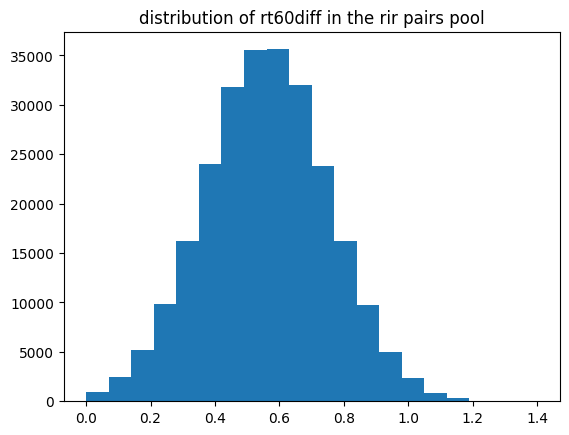

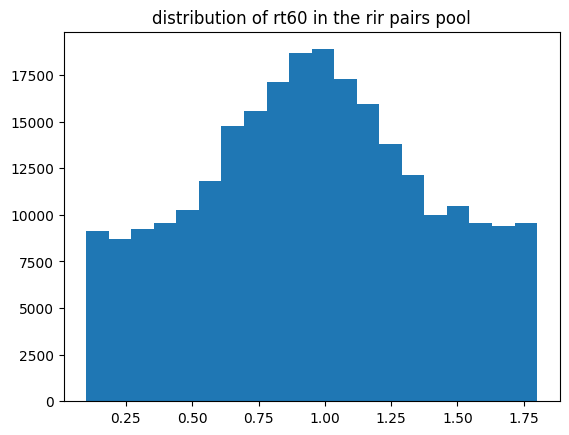

In [11]:
# plot distribution of rt60 differences in the pairs
plt.figure()
plt.hist(rirs_train["rt60_diff"],bins =20)
plt.title("distribution of rt60diff in the rir pairs pool")
plt.show()

# plot distribution of rt60 differences in the pairs
plt.figure()
plt.hist(rirs_train["rt60_set"],bins =20)
plt.title("distribution of rt60 in the rir pairs pool")
plt.show()

In [46]:
# --------- CREATE METADATA FOR A DATASET BY COMBINING SPEECH AND RIRS --------

def assign_speech_files(rir,speech):
    num_extra_samples = len(rir) - len(speech)
    extra_samples = speech.sample(n=num_extra_samples, replace=True, random_state=42)
    speech_expanded = pd.concat([speech, extra_samples], ignore_index=True)
    rirs_speech= pd.concat([rir.reset_index(drop=True), speech_expanded.reset_index(drop=True)], axis=1,ignore_index=False)
    return rirs_speech 

rirs_speech_train= assign_speech_files(rirs_train,speech_train)
rirs_speech_test= assign_speech_files(rirs_test,speech_test)
rirs_speech_val= assign_speech_files(rirs_val,speech_val)

print(f"{len(rirs_speech_train)=}")
print(f"{len(rirs_speech_test)=}")
print(f"{len(rirs_speech_val)=}")

len(rirs_speech_train)=252000
len(rirs_speech_test)=54000
len(rirs_speech_val)=54000


In [47]:
print("Full dataset metadata (pairs of rirs with assigned speech). Separate for test, train and val:")

display(rirs_speech_train.head(5))
display(rirs_speech_test.head(5))
display(rirs_speech_val.head(5))

Full dataset metadata (pairs of rirs with assigned speech). Separate for test, train and val:


,gen_pair_nr,rt60_diff,rt60_set,volume,room_x,room_y,room_z,mic_pos_x,mic_pos_y,mic_pos_z,...,mfp_masp_stats,rt30_meas,rt20_meas,edt_meas,c50_meas,ir_file_path,ir_clone_file_path,split,database_speech,speech_file_path
0,0,0.314,0.787,1128.26,11.39,18.23,5.43,4.211025,9.760310,1.748819,...,6.119707,1.103947,1.057706,0.855258,1.027292,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1139...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
1,2594,0.314,1.101,855.72,11.84,17.04,4.24,4.666803,9.668752,1.486666,...,5.277129,1.818040,1.832993,1.658078,-8.261207,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1184...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
2,0,0.442,0.787,1128.26,11.39,18.23,5.43,4.211025,9.760310,1.748819,...,6.119707,1.103947,1.057706,0.855258,1.027292,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1139...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
3,6642,0.442,1.229,144.89,5.45,7.06,3.77,1.467620,2.867389,1.581617,...,3.387641,1.620829,1.576613,1.462438,-2.674682,/home/ubuntu/Data/synth_rirs_new/monoRIR_x545y...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
4,0,0.371,0.787,1128.26,11.39,18.23,5.43,4.211025,9.760310,1.748819,...,6.119707,1.103947,1.057706,0.855258,1.027292,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1139...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...


,gen_pair_nr,rt60_diff,rt60_set,volume,room_x,room_y,room_z,mic_pos_x,mic_pos_y,mic_pos_z,...,mfp_masp_stats,rt30_meas,rt20_meas,edt_meas,c50_meas,ir_file_path,ir_clone_file_path,split,database_speech,speech_file_path
0,7000,0.829,1.588,3324.10,18.44,24.54,7.34,7.916276,14.521388,1.860953,...,8.649789,2.432197,2.371351,1.943766,-6.999614,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1844...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,test,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
1,7197,0.829,0.759,502.07,11.81,15.28,2.78,4.635979,9.007964,1.545580,...,3.922867,1.414618,1.483748,1.381927,-6.748699,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1181...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,test,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
2,7000,0.724,1.588,3324.10,18.44,24.54,7.34,7.916276,14.521388,1.860953,...,8.649789,2.432197,2.371351,1.943766,-6.999614,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1844...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,test,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
3,8161,0.724,0.864,935.92,16.84,17.72,3.14,8.156945,4.992222,1.002694,...,4.605248,1.700799,1.764797,1.327432,-1.064642,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1684...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,test,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
4,7000,0.403,1.588,3324.10,18.44,24.54,7.34,7.916276,14.521388,1.860953,...,8.649789,2.432197,2.371351,1.943766,-6.999614,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1844...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,test,EARS,/home/ubuntu/Data/EARS/p021/rainbow_08_fast.wav


,gen_pair_nr,rt60_diff,rt60_set,volume,room_x,room_y,room_z,mic_pos_x,mic_pos_y,mic_pos_z,...,mfp_masp_stats,rt30_meas,rt20_meas,edt_meas,c50_meas,ir_file_path,ir_clone_file_path,split,database_speech,speech_file_path
0,8500,0.804,0.948,3065.29,15.56,29.42,6.69,5.745628,18.653880,1.375946,...,8.073154,1.526996,1.560374,1.330735,-13.349899,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1556...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,val,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
1,9849,0.804,1.752,1594.99,18.89,22.51,3.75,11.600701,6.777889,1.406449,...,5.494061,3.434866,3.679734,3.396046,-20.552719,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1889...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,val,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
2,8500,0.713,0.948,3065.29,15.56,29.42,6.69,5.745628,18.653880,1.375946,...,8.073154,1.526996,1.560374,1.330735,-13.349899,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1556...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,val,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
3,9196,0.713,0.235,98.68,5.33,9.26,2.00,3.933216,4.844553,1.490701,...,2.513799,0.369157,0.350202,0.307564,10.070940,/home/ubuntu/Data/synth_rirs_new/monoRIR_x533y...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,val,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...
4,8500,0.505,0.948,3065.29,15.56,29.42,6.69,5.745628,18.653880,1.375946,...,8.073154,1.526996,1.560374,1.330735,-13.349899,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1556...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,val,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...


In [ ]:
# --------- SAVE FINAL DATASET METADATA --------

from datetime import datetime
date_tag = datetime.now().strftime("%d-%m-%Y--%H-%M")

dataset_metadata = pd.concat([rirs_speech_train, rirs_speech_test, rirs_speech_val], ignore_index=True)
dataset_metadata = dataset_metadata.reset_index(drop=True)
dataset_metadata["pair_idx"] = dataset_metadata.index // 2  # Integer division groups every two rows


dataset_metadata_pilot=pd.concat([rirs_speech_train[rirs_speech_train.index<int(0.01*len(rirs_speech_train))], 
                                  rirs_speech_test[rirs_speech_test.index<int(0.01*len(rirs_speech_test))], 
                                  rirs_speech_val[rirs_speech_val.index<int(0.01*len(rirs_speech_val))]], ignore_index=True)

# save metadata to csv:
dataset_metadata.to_csv("../dataset-metadata/"+ date_tag + "_data_set_t60diff.csv")
# create pilot csv:
dataset_metadata_pilot.to_csv("../dataset-metadata/"+ date_tag + "_data_set_t60diff_pilot.csv")

dataset_metadata.head(20)

,gen_pair_nr,rt60_diff,rt60_set,volume,room_x,room_y,room_z,mic_pos_x,mic_pos_y,mic_pos_z,...,rt30_meas,rt20_meas,edt_meas,c50_meas,ir_file_path,ir_clone_file_path,split,database_speech,speech_file_path,pair_idx
0,0,0.314,0.787,1128.26,11.39,18.23,5.43,4.211025,9.760310,1.748819,...,1.103947,1.057706,0.855258,1.027292,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1139...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,0
1,2594,0.314,1.101,855.72,11.84,17.04,4.24,4.666803,9.668752,1.486666,...,1.818040,1.832993,1.658078,-8.261207,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1184...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,0
2,0,0.442,0.787,1128.26,11.39,18.23,5.43,4.211025,9.760310,1.748819,...,1.103947,1.057706,0.855258,1.027292,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1139...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,1
3,6642,0.442,1.229,144.89,5.45,7.06,3.77,1.467620,2.867389,1.581617,...,1.620829,1.576613,1.462438,-2.674682,/home/ubuntu/Data/synth_rirs_new/monoRIR_x545y...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,1
4,0,0.371,0.787,1128.26,11.39,18.23,5.43,4.211025,9.760310,1.748819,...,1.103947,1.057706,0.855258,1.027292,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1139...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,2
5,5096,0.371,1.158,2314.55,18.51,23.16,5.40,7.423757,14.400865,1.675095,...,1.886495,1.920048,1.799303,-11.192484,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1851...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,2
6,0,0.566,0.787,1128.26,11.39,18.23,5.43,4.211025,9.760310,1.748819,...,1.103947,1.057706,0.855258,1.027292,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1139...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,3
7,4162,0.566,0.221,97.44,6.22,6.63,2.36,1.903134,3.354529,1.275503,...,0.289725,0.294421,0.316731,8.495045,/home/ubuntu/Data/synth_rirs_new/monoRIR_x622y...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,3
8,0,0.499,0.787,1128.26,11.39,18.23,5.43,4.211025,9.760310,1.748819,...,1.103947,1.057706,0.855258,1.027292,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1139...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,4
9,1080,0.499,1.286,1492.17,12.78,23.63,4.94,8.609674,15.448777,1.616293,...,2.251771,2.271554,2.032836,-9.304485,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1278...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,4


In [73]:
# Check saved database
df = pd.read_csv("../dataset-metadata/14-02-2025--12-20_data_set_t60diff.csv",index_col=0)
df.head(20)


,gen_pair_nr,rt60_diff,rt60_set,volume,room_x,room_y,room_z,mic_pos_x,mic_pos_y,mic_pos_z,...,rt30_meas,rt20_meas,edt_meas,c50_meas,ir_file_path,ir_clone_file_path,split,database_speech,speech_file_path,pair_idx
0,0,0.314,0.787,1128.26,11.39,18.23,5.43,4.211025,9.760310,1.748819,...,1.103947,1.057706,0.855258,1.027292,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1139...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,0
1,2594,0.314,1.101,855.72,11.84,17.04,4.24,4.666803,9.668752,1.486666,...,1.818040,1.832993,1.658078,-8.261207,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1184...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,0
2,0,0.442,0.787,1128.26,11.39,18.23,5.43,4.211025,9.760310,1.748819,...,1.103947,1.057706,0.855258,1.027292,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1139...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,1
3,6642,0.442,1.229,144.89,5.45,7.06,3.77,1.467620,2.867389,1.581617,...,1.620829,1.576613,1.462438,-2.674682,/home/ubuntu/Data/synth_rirs_new/monoRIR_x545y...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,1
4,0,0.371,0.787,1128.26,11.39,18.23,5.43,4.211025,9.760310,1.748819,...,1.103947,1.057706,0.855258,1.027292,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1139...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,2
5,5096,0.371,1.158,2314.55,18.51,23.16,5.40,7.423757,14.400865,1.675095,...,1.886495,1.920048,1.799303,-11.192484,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1851...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,2
6,0,0.566,0.787,1128.26,11.39,18.23,5.43,4.211025,9.760310,1.748819,...,1.103947,1.057706,0.855258,1.027292,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1139...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,3
7,4162,0.566,0.221,97.44,6.22,6.63,2.36,1.903134,3.354529,1.275503,...,0.289725,0.294421,0.316731,8.495045,/home/ubuntu/Data/synth_rirs_new/monoRIR_x622y...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,3
8,0,0.499,0.787,1128.26,11.39,18.23,5.43,4.211025,9.760310,1.748819,...,1.103947,1.057706,0.855258,1.027292,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1139...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,4
9,1080,0.499,1.286,1492.17,12.78,23.63,4.94,8.609674,15.448777,1.616293,...,2.251771,2.271554,2.032836,-9.304485,/home/ubuntu/Data/synth_rirs_new/monoRIR_x1278...,/home/ubuntu/Data/synth_rirs_new/clone_monoRIR...,train,VCTK,/home/ubuntu/Data/VCTK/wav48_silence_trimmed/p...,4


### 1. What data was exactly used in training? 

a) Speech pool: 
- VCTK (88328 audio files) + PTBD data bases (4718 audio files) + EARS (7276 audio files)
- In total: 93046 audio files

b) RIR pool: 
- 20 000 RIRs (10 000 pairs) from different rooms with varying source-receiver distance 
- Exact procedure is described in the script "rir_dataset.ipynb" (commited february 2025)
- The difference between pairs of rirs is controlled - the absolute differerence rt60diff ~N(0.5,02)

c) Style transfer data set
- 252k (train) + 54k (train) + 54k (val) samples = 126k (train) + 27k (test) + 27k (val) pairs consisting of 2 audio files and 2 rirs each
- To be able to create 352k samples, both speech and rirs are repeated
- But there is a form of augmentation in training:
- Every 2s audio sample is chosen randomly from a longer file
- For each rir we also have a "clone" rir - from the same room but from a different source position, so they can be used interchangeably while training

- 1 data point -> inputs: s1r1, s2r2 and ground truth: s1r2 
- Each audio sample is 2s randomly chosen from the audio file


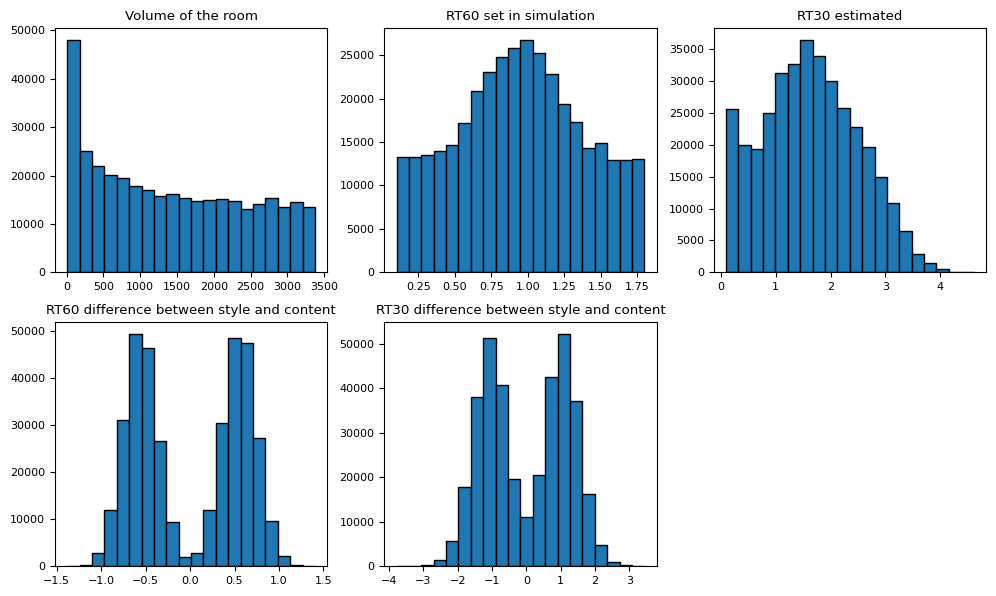

In [74]:
# get rt60 difference between style and content
df["diff_rt60"] =df["rt60_true"].diff()
df["diff_rt30"] =df["rt30_meas"].diff()
df.loc[0::2, 'diff_rt60'] = df['diff_rt60'].shift(periods=-1)
df.loc[0::2, 'diff_rt30'] = df['diff_rt30'].shift(periods=-1)


plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 8})
plt.subplot(2,3,1)
plt.hist(df["volume"], bins=20, edgecolor='black')
plt.title("Volume of the room")
plt.subplot(2,3,2)
plt.hist(df["rt60_true"], bins=20, edgecolor='black')
plt.title("RT60 set in simulation")
plt.subplot(2,3,3)
plt.hist(df["rt30_meas"], bins=20, edgecolor='black')
plt.title("RT30 estimated")
plt.subplot(2,3,4)
plt.hist(df["diff_rt60"], bins=20, edgecolor='black')
plt.title("RT60 difference between style and content")
plt.subplot(2,3,5)
plt.hist(df["diff_rt30"], bins=20, edgecolor='black')
plt.title("RT30 difference between style and content")
plt.tight_layout()
plt.show()


# Simulation with masp uses rt60 like this: 
# # Compute absorption coefficients for desired rt60 and room dimensions
# abs_walls,rt60_true = srs.find_abs_coeffs_from_rt(room, rt60)
# # Small correction for sound absorption coefficients:
# if sum(rt60_true-rt60>0.05*rt60_true)>0 :
#     abs_walls,rt60_true = srs.find_abs_coeffs_from_rt(room, rt60_true + abs(rt60-rt60_true))


100322


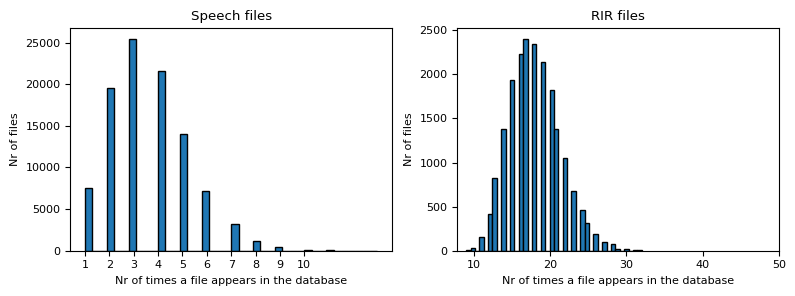

In [75]:
# REPETITIONS OF FILES ACROSS DATA BASE

print(len(df.groupby("speech_file_path").size()))

# How many times each file is repeated across the whole data base
grouped_speech = df.groupby("speech_file_path")
grouped_rir = df.groupby("ir_file_path")

# How many times the files are repeated 
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.hist(grouped_speech.size(), bins=40, edgecolor='black')
plt.xticks([1,2,3,4,5,6,7,8,9,10])
plt.xlabel("Nr of times a file appears in the database")
plt.ylabel("Nr of files")
plt.title("Speech files")
plt.subplot(1,2,2)
plt.hist(grouped_rir.size(), bins=40, edgecolor='black')
plt.xticks(np.arange(10,55,10))
plt.xlabel("Nr of times a file appears in the database")
plt.title("RIR files")
plt.ylabel("Nr of files")
plt.tight_layout()
plt.show()


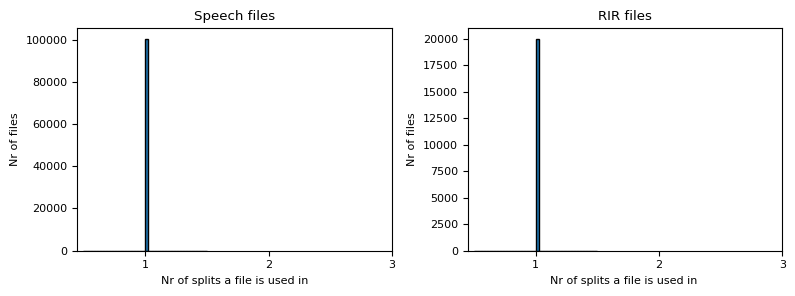

In [76]:
# TRAIN-TEST LEAKAGE 
split_counts_speech = grouped_speech['split'].nunique()
split_counts_rir = grouped_rir['split'].nunique()

# How many times the files are repeated 
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.hist(split_counts_speech, bins=40, edgecolor='black')
plt.xticks([1,2,3])
plt.xlabel("Nr of splits a file is used in")
plt.ylabel("Nr of files")
plt.title("Speech files")
plt.subplot(1,2,2)
plt.hist(split_counts_rir, bins=40, edgecolor='black')
plt.xticks([1,2,3])
plt.xlabel("Nr of splits a file is used in ")
plt.title("RIR files")
plt.ylabel("Nr of files")
plt.tight_layout()
plt.show()


In [77]:
# check metadata in combination with a dataset class definition
sys.path.append('../src')

import helpers as hlp
import dataset as ds
from IPython.display import Audio

importlib.reload(hlp)
importlib.reload(ds)

config=hlp.load_config("../config/basic.yaml")
config["split"]="test"
config["df_metadata"]="/home/ubuntu/joanna/reverb-match-cond-u-net/dataset-metadata/14-02-2025--12-20_data_set_t60diff.csv"
config["p_noise"]=0
dataset=ds.DatasetReverbTransfer(config)
# get one data sample 
sContent, sStyle, sTarget, sAnecho, sAnecho2 = dataset[200]

# playback for the data sample
audios=[sContent, sStyle, sTarget]
names=["sContent", "sStyle", "sTarget"]

for i,audio in enumerate(audios):
    print(names[i])
    audio=audio.squeeze(0).cpu()
    display(Audio(audio,rate=48e3))



sContent


sStyle


sTarget
